### 用逻辑回归预测银行客户是否会开设定期存款账户

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
import os
os.chdir('E:\python\实战\机器学习实战\Cp5_logisticRegresson')

#### 1、读取数据，并初步查看数据

In [2]:
df = pd.read_csv('./data/banking.csv')
print('查看缺失值状况：', df.isnull().sum())
print('education的种类有：\n', df['education'].unique())

查看缺失值状况： age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
education的种类有：
 ['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']


#### 2、初步数据清洗

y的取值状况：
 0    36548
1     4640
Name: y, dtype: int64


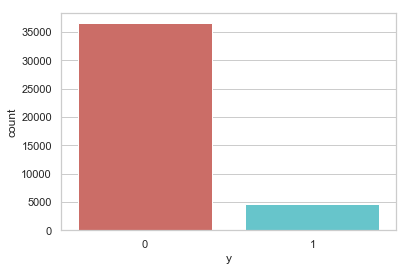

未开户的百分比为88.73%
开户的百分比为11.27%


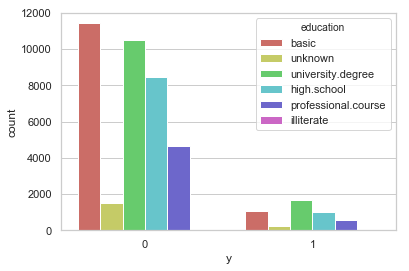

In [3]:
df['education'] = np.where(df['education']=='basic.4y', 'basic', df['education'])
df['education'] = np.where(df['education']=='basic.9y', 'basic', df['education'])
df['education'] = np.where(df['education']=='basic.6y', 'basic', df['education'])
print('y的取值状况：\n', df['y'].value_counts())
sns.countplot(x=df['y'], data=df, palette='hls')
plt.show()
## 可以发现y的0、1取值显著不平衡，所以后续需要进行过采样处理，以解决数据不平衡问题
count_no_sub = len(df[df['y']==0])
count_sub = len(df[df['y']==1])
print('未开户的百分比为%.2f'%(count_no_sub/(count_no_sub+count_sub)*100) + str('%'))
print('开户的百分比为%.2f'%(count_sub/(count_no_sub+count_sub)*100) + str('%'))

# 在预测之前了解数据
## 查看一下开户与未开户人的特征差异
df1 = df.groupby('y').mean()
df1 = df.groupby('job').mean()    # 按工作划分
df1 = df.groupby('marital').mean()    # 按婚姻状况
df1 = df.groupby('education').mean()    # 按教育状况
sns.countplot(x=df['y'], data=df, hue='education', palette='hls')
plt.show()

#### 3、特征工程（对类别型数据进行筛选，考虑是否将其放入模型）

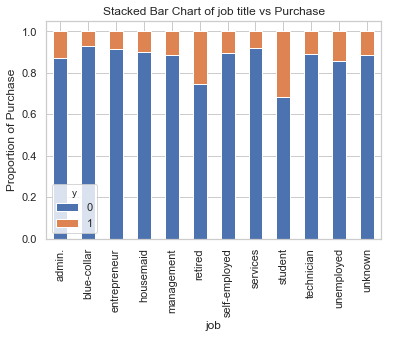

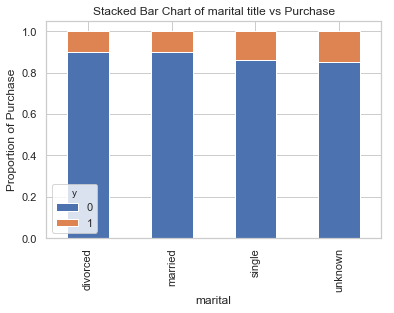

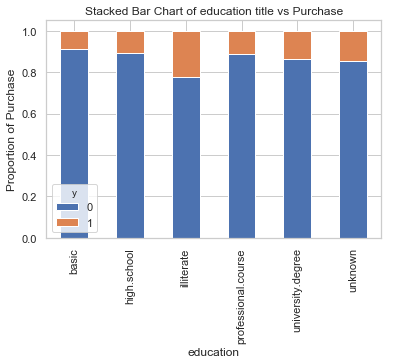

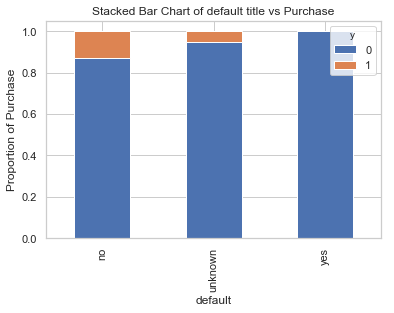

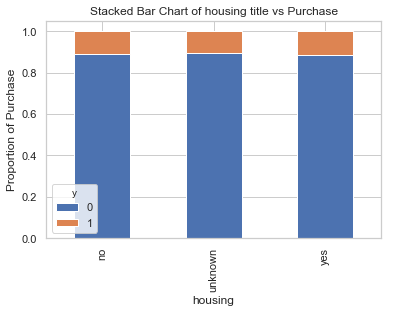

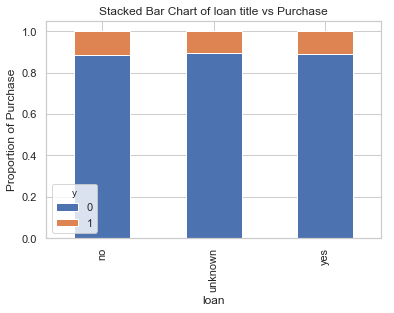

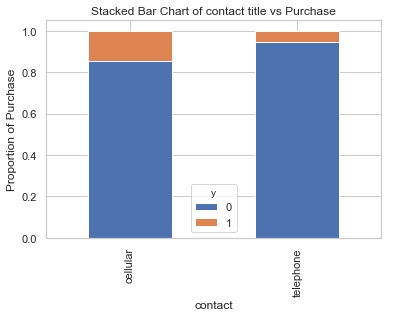

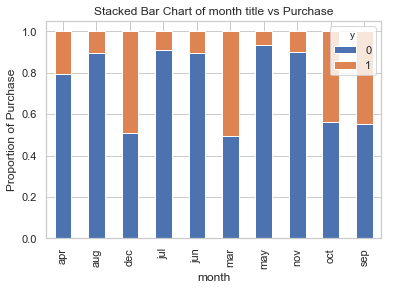

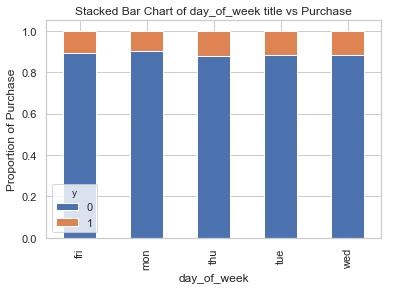

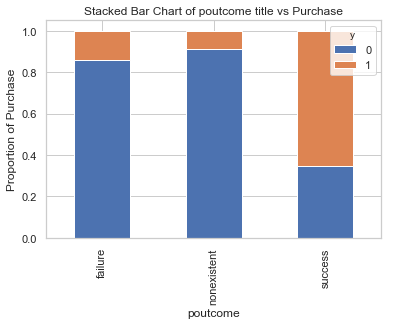

c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


过采样以后的数据量:  51134
其中未开户的用户数量为： 25567
其中已开户的用户数量为： 25567


In [4]:
# 绘制堆叠图，以查看各个因素对是否购买的影响差异，以进一步选择特征
'''
table = pd.crosstab(df.job, df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Job title vs Purchase')    # 堆叠长条图
plt.xlabel('job')
plt.ylabel('Proportion of Purchase')
# plt.savefig('perchase_vs_job')
'''
## 可以看出不同职位的人购买存款的频率不一样，因此职称可以是一个良好的预测因素
### 先筛选出属性为类别型object的列，并将其做成列表
object_lst = df.dtypes
object_lst = list(object_lst[object_lst=='object'].index)
### 再对每个类别型特征绘制堆叠图
def plot_stack(dfi,dfy, clname, savepath=None):
    table = pd.crosstab(dfi, dfy)
    table.div(table.sum(axis=1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title('Stacked Bar Chart of {} title vs Purchase'.format(clname))
    plt.xlabel(clname)
    plt.ylabel('Proportion of Purchase')
    plt.show()
    if savepath is not None:
        plt.savefig(savepath)
### 最后绘制每个类别属性的堆叠图
for every_object in object_lst:
    plot_stack(df[every_object], df.y, every_object)
#### 最后的结论是：job\education\default\contact\month\poutcome是良好的区分指标
####               martial\day_of_week\似乎不是良好的指标，不是很明显
####               housing\loan\不是良好的区分指标，舍弃掉
cat_var = ['job', 'education', 'default', 'contact', 'month', 'poutcome']   # 筛选出的类别特征
# 将其转成one-hot编码
for var in cat_var:
    cat_list = pd.get_dummies(df[var], prefix=var)
    df = df.join(cat_list)
df_final = df.drop(cat_var, axis=1)
df_final2 = df_final.drop(['marital', 'housing', 'loan', 'day_of_week'], axis=1)    # 这些类别型列没有区分性，所以舍弃

# 由于正负样本比例严重失调，所以进行过采样
## 使用SMOTE算法进行过采样，对已经开户的训练集用户进行上采样
x = df_final2.loc[:, df_final2.columns!='y']
y = df_final2.loc[:, df_final2.columns=='y'].values.ravel()    # 扁平化函数，书画微一维数组
from imblearn.over_sampling import SMOTE
so = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns
so_data_x, so_data_y = so.fit_sample(x_train, y_train)    ## 【注意：放入的是训练集】
so_data_x = pd.DataFrame(data=so_data_x, columns=columns)
so_data_y = pd.DataFrame(data=so_data_y, columns=['y'])
## check the number of data
print('过采样以后的数据量: ', len(so_data_x))
print('其中未开户的用户数量为：', len(so_data_y[so_data_y['y']==0]))
print('其中已开户的用户数量为：', len(so_data_y[so_data_y['y']==1]))
### 此时正负样本数量已经达到平衡

#### 4、训练模型

c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


预测的精确率为： 0.8608076393946751
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10981
           1       0.44      0.88      0.58      1376

    accuracy                           0.86     12357
   macro avg       0.71      0.87      0.75     12357
weighted avg       0.92      0.86      0.88     12357



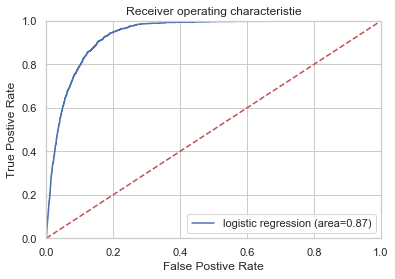

In [5]:
clf = LogisticRegression()
clf.fit(so_data_x, so_data_y.values.reshape(-1, 1))
y_pred = clf.predict(x_test)
print('预测的精确率为：', accuracy_score(y_test, y_pred))
# 评价模型
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(x_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='logistic regression (area=%0.2f)'%logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('Receiver operating characteristie')
plt.legend(loc='lower right')
# plt.savefig()
plt.show()